In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [2]:
import sys
# Checking version as to correctly type hint, python 3.8 and earlier require imports from the typing module
# Additionally python 3.9 requires optional and union to be imported
sys.version


'3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]'

Fetch the MNIST dataset. The MNIST dataset is a popular ML datasets containing 70000 handwritten digits. It is a popular dataset for people to test new classification methods or ml pipelines on, due to the fact that it is widely used, extensive and contains labels for each set of features. Furthermore the dataset is also good as it is representative of what one may see in real life when analysing handwriting with there being a fair amount of outliers. Although the task might seem simple, the nuance exists in creating a classifier that performs well with a high accuracy, even on outliers.

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier

mnist = fetch_openml('mnist_784', as_frame = False)
X,y = mnist.data, mnist.target 


/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Let us plot a couple of the images, just to play around with matplotlib and get an idea of what type of data we are working with

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
%matplotlib inline

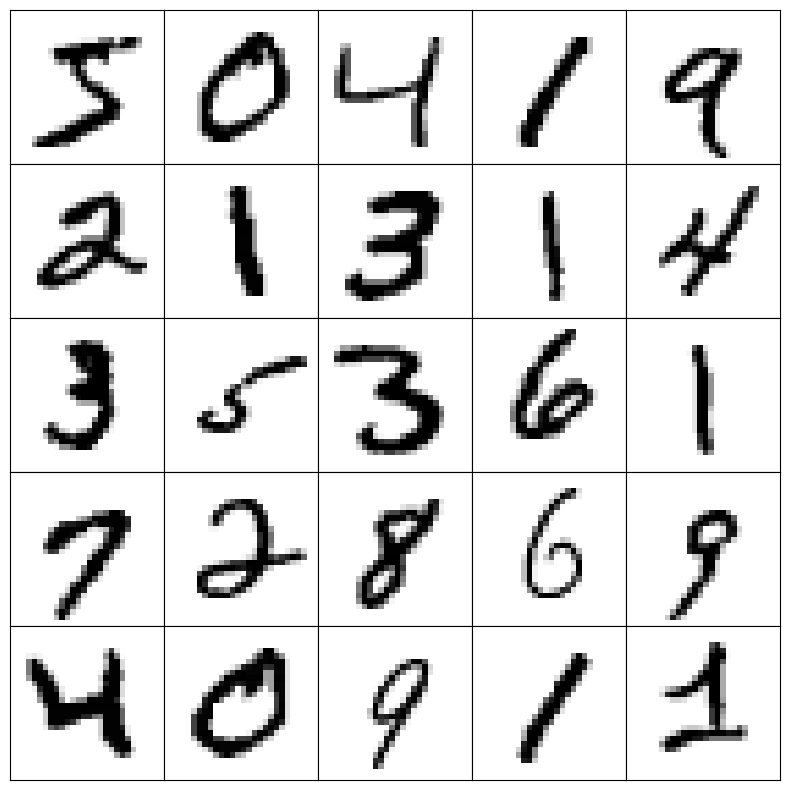

In [6]:

def plot_sample(array: np.array, sample_square_size: int, plot_size: int = 10):
    if sample_square_size**2 > array.size:
        raise ValueError(f'Not enough samples in dataset, expected an array of shape: {(sample_square_size**2,784)} or larger')
    fig = plt.figure(figsize=(plot_size,plot_size))
    # rect grid starts from top left corner
    grid = ImageGrid(fig, rect = 111, nrows_ncols=(sample_square_size,sample_square_size), axes_pad=0, label_mode='1',)
    for index,ax in enumerate(grid):
        # don't specify extent yet
        entry = array[index].reshape(28,28)
        # see https://matplotlib.org/stable/gallery/color/colormap_reference.html for more cmaps
        ax.imshow(entry, cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])

def plot_single(array):
    fig= plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    entry = array.reshape(28,28)
    ax.imshow(entry)
    ax.set_axis_off()



plot_sample(X,5)
    

The most intutitive way to approach such a problem is for each datapoint in our test datset we should classify it based on what image is most similar to it, so instead of learning anything, we lazily evaluate for each new item that we get. This is exactly what the Kneighbors classifier does. 

Before we proceed, let us isolate our test data. As we are dealign with multiclass data, and do to how the KNClassifier works as we just went over, we want to perform a stratified split. For this dataset, this is very simple as it has already been shulffled and stratified for us.

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = X[:50000], X[50000:60000], X[60000:],y[:50000],y[50000:60000],y[60000:]


Let us see how our KNNClassifier performs without any hyperparameter tuning

['5']
5


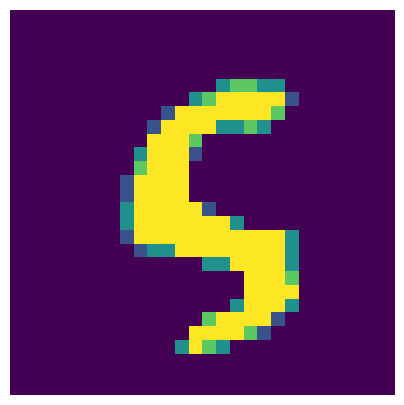

In [8]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
prediction = knn_clf.predict(X_val[10].reshape(1, -1))
print(prediction)
print(y_val[10])
plot_single(X_val[10])


Great, so for a single entry, even when the 5 looks more like an 's' than a 5 (at this point we are thankful that we are simply dealing with number classification), we can predict which number it is correctly. Let us evaluate the current performance of our classifier on the training set.




In [9]:
# Warning, this cell may run for a couple of minutes

from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import cross_val_predict



y_train_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)


In [10]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, y_train_pred)
print(accuracy)

0.96382


To get to an accuracy above 97%, let us try different parameters for our KNeighboursClassifier

In [11]:

from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors':[3,7,10]}
grid_search = GridSearchCV(knn_clf,param_grid, cv=3)
cv_results = grid_search.fit(X_train, y_train).cv_results_
cv_df = pd.DataFrame(cv_results)


As we have now reached a suitable accuracy for our model, thus fulfilling the requiremen

In [12]:
cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.206184,0.001782,16.245570,0.410014,3,{'n_neighbors': 3},0.965681,0.965501,0.964599,0.96526,0.000473,1
1,0.206740,0.001321,16.061210,0.224329,7,{'n_neighbors': 7},0.962081,0.962621,0.962679,0.96246,0.000269,2
2,0.208007,0.000325,16.301294,0.302643,10,{'n_neighbors': 10},0.960161,0.960461,0.960098,0.96024,0.000158,3


It seems that our model is struggling to overcome the 96% threshold currently, we thus have 3 options, either decrease the decision threshold or to decrease the amount of neighbors that are taken into consideration or somehow augment our data. Decreasing the amount of neighbors really only seems like a strategy with which we will overfit to this dataset, so now we are left with 2 options. I propose introducing noise to our dataset and this might make the nearest neighbours thus be based on stronger features that persist even after noise is introduced and thus possibly improve our model.

In [13]:
print(X_train.shape)

(50000, 784)


(50000, 784)


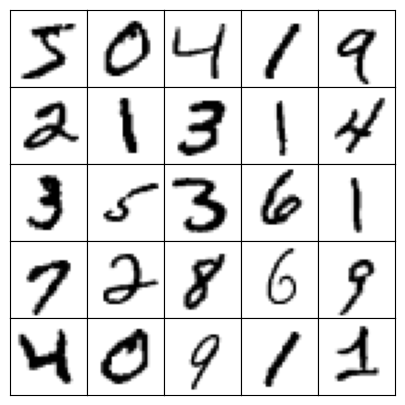

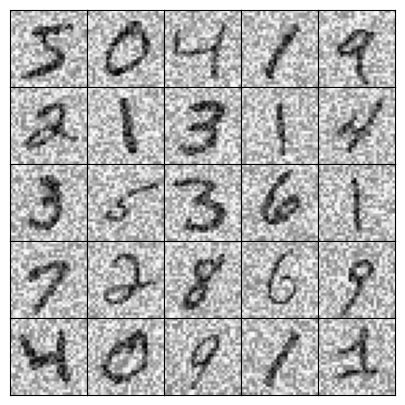

In [14]:
np.random.seed(42)
random_generator = np.random.default_rng(42)
random_noise = ((255-0) * random_generator.random(size=(50000,784)) + 0)
random_noise = np.round(random_noise,decimals=0)

# Discouraged approach, but simpler
# random_noise = np.random.randint(0,255,size=(50000,784))
print(random_noise.shape)
X_train_noisy = X_train + random_noise

plot_sample(X,5,5)
plot_sample(X_train_noisy,5,5)


In [15]:
knn_clf_noise = KNeighborsClassifier()
knn_clf_noise.fit(X_train_noisy, y_train)
y_train_noise_pred = cross_val_predict(knn_clf_noise, X_train_noisy, y_train, cv=3)

accuracy = accuracy_score(y_train, y_train_noise_pred)

In [16]:
print(accuracy)

0.93974


Introducing noise decreased our accuracy by 2 points. A note that I made when writing this notebook is that when not usign cross-validation it actually shows an increase of 3 points, thsi jsut shows how important it is to use out of sample data to evaluate the models performance. 

I also tested the approach where I introduce noise, but the noise has a maximum value of 125, this was chosen arbitrarily, just to test if introducing noise could somehow improve performance by reducing the weighting of a singular 'feature' of the number for example decreading the weight of the 'cross' in the middle of an 8 by adding noise and thus other features may be weighted higher, this lead to a .2 point decrease in accuracy of the model.

My next approach that would be inline with is to for each image identify a minimal box around the number and then only introduce noise in that area, thus targeting the positions where we introduce noise. My idea with this is to decrease the weighting of the white pixels. While this idea sounds good in theory it also does not seem effeciently computable to me, I can only think of the bruteforce method in O(n^2) atm just to find the points.

Furthermore, something that I realized is kind of weird about our model is the pixel values, that is, we have black and white images, the colour doesn't matter, but we are taking in the nuances of the color into our model, whereas I as a human when identifying what color would be used, would only be concerned with if I can *clearly* see something there or not. I thus suggest 'smoothing' the images such that every pixel has a binary value of white or black. I realise in hindsight that this is just a form of scaling, albeit an extreme method, so I wonder how this approach performs when compared to min-max standardization or normalization.

In [17]:
print(X_train[1])

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  51. 159. 253. 159.  50.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  48. 238. 252. 252. 252. 237.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  54.
 227. 253. 252. 239. 233. 252.  57.   6.   0.   0.   0.   0.   0.   0.
   0. 

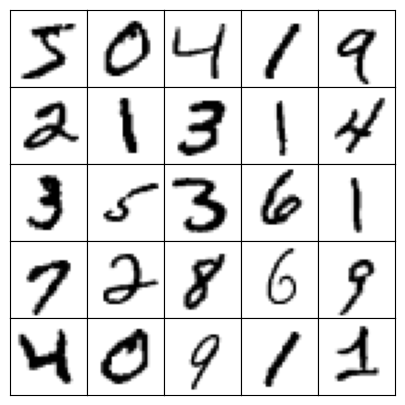

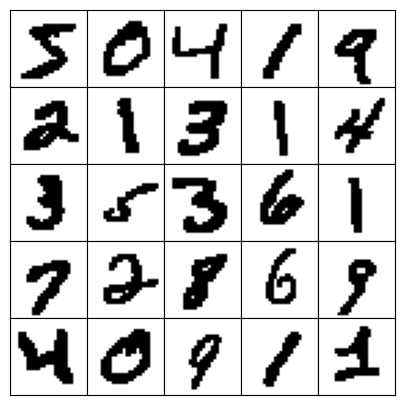

In [18]:
X_train_flat = X_train.copy()

for i in X_train_flat:
    i[i>0] = 255

plot_sample(X,5,5)
plot_sample(X_train_flat,5,5)


Just looking at the images I can tell that for some samples the nuance is reduced, but I hope that this will still make us have a higher accuracy and also be generalisable to the validation set. 

In [19]:
# I keep on making new classifiers as to compare them in the end.
# Also knn_clf evaluates lazily, so I do not want to mix up two approaches in one classifier
knn_clf_flat = KNeighborsClassifier(n_neighbors=5)
knn_clf_flat.fit(X_train_flat, y_train)
y_flat_pred = cross_val_predict(knn_clf_flat, X_train_flat, y_train, cv=3)
accuracy = accuracy_score(y_train, y_flat_pred)



In [20]:
print(accuracy)

0.9606


Sadly this approach does not increase the accuracy either, let us scale our dataset and see the effect. Scaling is recommended as ML algorithms perform better when all features have rougly the same scale. Here we have 784 features, so scaling should be quite important. We wil use standardization here due to the fact that most values are either close to 255 or close to 0 meaning if we use a min max scaler, most values would be pushed to 1 resp. 0 with fewer values in the middle. Furthermore, as some of our features have larger scale than others, those features would thus dominate our distance calculation. 



In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [22]:
stand_scl = StandardScaler()
X_train_stand =stand_scl.fit_transform(X_train)

min_max_scl = MinMaxScaler()
X_train_min_max = min_max_scl.fit_transform(X_train)

knn_std = KNeighborsClassifier()
knn_min_max  = KNeighborsClassifier()
knn_std.fit(X_train_stand,y_train)
knn_min_max.fit(X_train_min_max,y_train)

y_stand_pred = cross_val_predict(knn_std, X_train_stand, y_train, cv=3)
y_min_max_pred = cross_val_predict(knn_min_max, X_train_min_max, y_train, cv=3)



In [23]:
accuracy = accuracy_score(y_train, y_stand_pred)
print(accuracy)
accuracy = accuracy_score(y_train, y_min_max_pred)
print(accuracy)

0.93622
0.9638


It seems that through (simple) data augmentation alone we cannot improve the accuracy of the model. Let us one check if any of the models have any merit usign the validation set, we will also plot some precision recall-curves and go into the theory of that for the fun of it,and we will finally move on to finding ideal hyperparameters for our model.

In [24]:
# Predictions for flat-trained KNN, without flattened data
y_flat_val_pred = knn_clf_flat.predict(X_val)
accuracy = accuracy_score(y_val, y_flat_val_pred)
print(f'Flat Accuracy, base data: {accuracy:.4f}')

# Predictions for flat-trained KNN, with flattened data
X_val_flat = X_val.copy()
for i in X_val_flat:
    i[i>0] = 255
y_flat_val_pred = knn_clf_flat.predict(X_val_flat)
accuracy = accuracy_score(y_val, y_flat_val_pred)
print(f'Flat Accuracy, flattened data {accuracy:.4f}')

# Predictions for noise-trained KNN without noise addition on dataset
y_noise_val_pred = knn_clf_noise.predict(X_val)
accuracy = accuracy_score(y_val, y_noise_val_pred)
print(f'Noise Accuracy, base data: {accuracy:.4f}')

# Predictions for noise-trained KNN with noise addition on dataset 
X_val_noise = X_val + random_noise[X_val.shape[0],:]
y_noise_val_pred = knn_clf_noise.predict(X_val_noise)
accuracy = accuracy_score(y_val, y_noise_val_pred)
print(f'Noise Accuracy, noise transformed: {accuracy:.4f}')

# Predictions for base KNN
y_val_pred = knn_clf.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Base Accuracy: {accuracy:.4f}')

# StandardScaler transformed
X_val_std = stand_scl.transform(X_val)
y_std_val_pred = knn_std.predict(X_val_std)
accuracy = accuracy_score(y_val, y_std_val_pred)
print(f'Standard Scaled Accuracy: {accuracy:.4f}')

# MinMaxScaler transformed
X_val_scl = min_max_scl.transform(X_val)
y_scl_val_pred = knn_min_max.predict(X_val_scl)
accuracy = accuracy_score(y_val, y_scl_val_pred)
print(f'Min-Max Scaled Accuracy: {accuracy:.4f}')


Flat Accuracy, base data: 0.9352
Flat Accuracy, flattened data 0.9665
Noise Accuracy, base data: 0.5035
Noise Accuracy, noise transformed: 0.9500
Base Accuracy: 0.9718
Standard Scaled Accuracy: 0.9496
Min-Max Scaled Accuracy: 0.9718


We can see that the classifiers for flat and noisy data perform worse (or horribly) if the data is not transformed beforehand. Our base classifier has a higher accuracy than on the train set which shows that it is generalising well to unseen data. We can see that the base KNN still performs the best. Let us visualise which classes (numbers) the classifiers perform well on, and which ones they struggle with. We will do this using the PR-curve

In [25]:
def plot_pr_curves(y_train_bin, y_score, suptitle:str | None):
    '''Plot precision/recall curves'''
    fig, ax = plt.subplots(figsize=(5, 5))  

    for i, label in enumerate(labels):
        precision, recall, thresholds = precision_recall_curve(y_train_bin[:, i], y_score[:, i])
        ax.plot(recall, precision, linewidth=2.0, label=f'Class {label}')
    if suptitle:
        fig.suptitle(suptitle)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curves')
    ax.legend(loc='best')

    plt.show()

[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


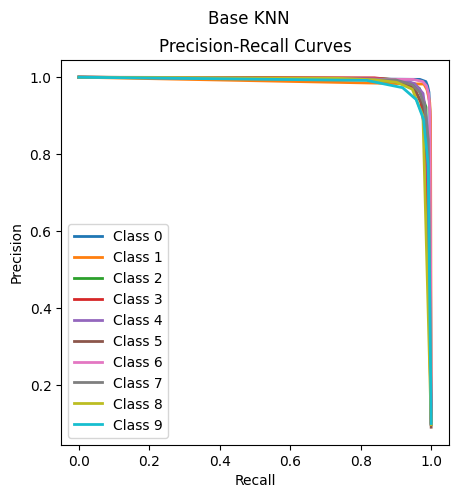

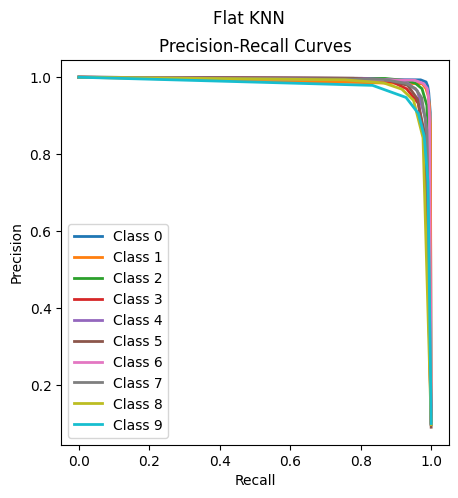

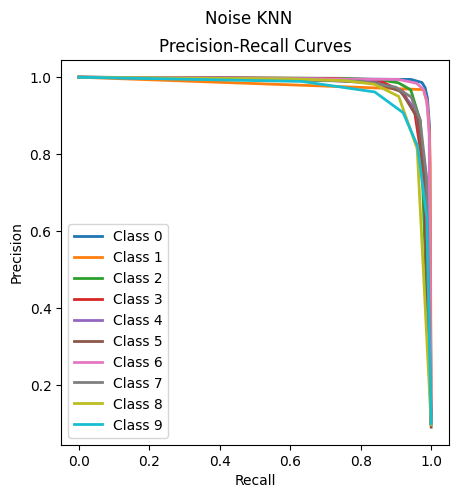

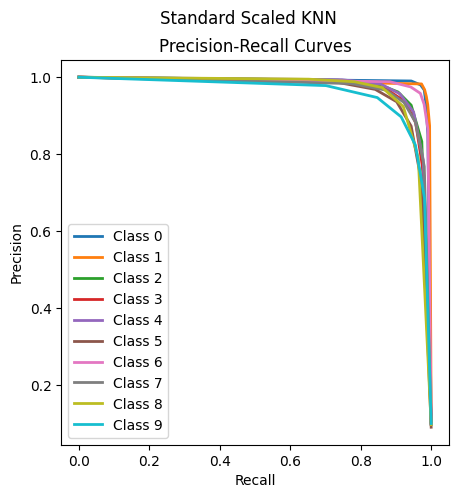

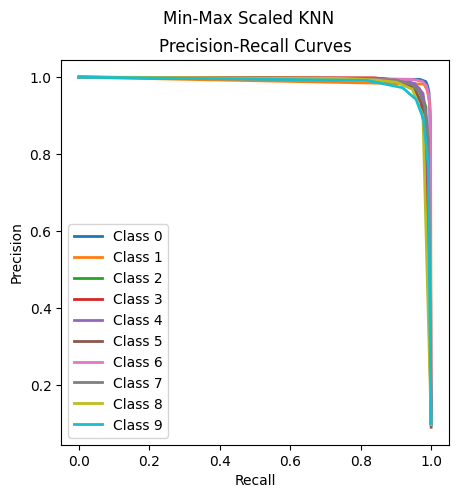

In [26]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize


labels = knn_clf.classes_
# binarize the labels as to simulate one v rest 
y_train_bin = label_binarize(y_train, classes=labels)
print(y_train_bin)

knn_models = [
    ("Base KNN", knn_clf, X_train),
    ("Flat KNN", knn_clf_flat, X_train_flat),
    ("Noise KNN", knn_clf_noise, X_train_noisy),
    ("Standard Scaled KNN", knn_std, X_train_stand),
    ("Min-Max Scaled KNN", knn_min_max, X_train_min_max)
]

for title, model, X in knn_models:
    y_score = cross_val_predict(model, X, y_train, cv=3, method='predict_proba')
    plot_pr_curves(y_train_bin, y_score, title)


Let us go over the code and what the goal of it is. First, we must binarize the classes, this measn transforming it into an array where the position representing the ith class has the value 1 if the sample is part of that class. We do this, as a precision recall curve and the terms precision and recall in general require a positive and negative class. When you call the precision_score or recall_score functions on a multinomial classification prediction and sample it performs some aggregation as to give you one value, but this isn't a native characteristic of said function. Thus for each input binarizing the target gives us an array such that we can treat the targets as  if we have a one v rest classification. 

To draw the precision recall curve, we also need access to the underlying probabilities that were used in the prediciton, for the knn this is simply the relative frequency of the classes among the closest neighbors. By comparing these to the theshold - noting that we have reframed the classification to one v rest - we can determine if at probablity x if we would classify it into the positive or negative class.

As the probability (threshold) goes higher, we classify more items into the negative class, thus the precision, which is tp/(tp+fp) goes higher and our recall tp/(tp+fn) becomes lower. Conversely if we lower the threshold then our recall will go higher as we will classify even more in the posititve class and thus we will have less fn and more tp. 

As Geron says, the answer to the question 'We want 99% precision' should always be 'At what recall?'. As the graphs show, you can get closer to 100% precision with even thsi model, but at the cost of the recall. 

So, how can we interpret this and what is the use-case of shifting the threshold? Well, there can be use-cases where shifting the threshold is important. Take the current task, a similar system is used in address identification for shipping. Here there are (financial) consequences for misidentifying a '1'  or a '9', it may thus be ideal to sacrifice recall as to have a system where if the number is clearly visible, then it will be identified, but if it isn't we do not risk misidentifying the number. In such cases we can then also trigger further steps in the pipeline for the n-most-likely candidates as to identify one among them, utilising steps that may be computationaly expensive and thus are not implemented for the entire dataset. 


Overall, many considerations must be made when increasing thresholds, doing so can lead to misleading metrics.

Now let us evaluate the graphs:

We can see that for our base KNN the easiest class to predict is the class 0 and the most dificult class to predict is class 9 (based on AUC). Overall we can see that we achieve very high precision and recall. 

Flattening, introducing noise, and scaling do not significantly improve model performance on easily classifiable digits. In fact, these transformations can slightly reduce the model’s ability to identify such digits with high confidence.

This can be observed in the precision-recall curves: the trade-off between precision and recall begins earlier (i.e., at lower recall values) for the transformed data.

While precision-recall curves are useful for visualizing performance, they are not directly comparable across models, since the actual score thresholds that generate these curves differ between models.

Therefore, we avoid interpreting exact positions or claiming threshold-specific behavior (e.g., “left = high threshold”) across models. Instead, we focus on overall curve shape and area under the curve as rough indicators of classifier confidence and tradeoff behavior.

To empirically compare two recall-precision curves, we can use the auc() or the average precision score, we will use the latter as it is less forgiving, less optimistic as it is not interpolated 
( see [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)).

Let us take the class 0 as a representative of the 'easy to predict' class and the class 9 as a representative of the 'hard to predict' class and see how our 'flattened' model compares to our base model. 


In [27]:
from sklearn.metrics import average_precision_score

y_val_bin = label_binarize(y_val,classes=labels)

# Out of sample predictions to produce metrics for the model
y_score_flat = knn_clf_flat.predict_proba(X_val)
y_score_base = knn_clf.predict_proba(X_val)


# Provide scores for both curves for both models
aps_0 =average_precision_score(y_val_bin[:,0], y_score_flat[:,0])
print(f'Average Precision Score on Label 0 for Model "Flat": {aps_0}')
aps_0 = average_precision_score(y_val_bin[:,0], y_score_base[:,0])
print(f'Average Precision Score on Label 0 for Model "Base": {aps_0}')

aps_9 =average_precision_score(y_val_bin[:,9], y_score_flat[:,9])
print(f'Average Precision Score on Label 9 for Model "Flat": {aps_9}')
aps_9 = average_precision_score(y_val_bin[:,9], y_score_base[:,9])
print(f'Average Precision Score on Label 9 for Model "Base": {aps_9}')



Average Precision Score on Label 0 for Model "Flat": 0.9945071115128475
Average Precision Score on Label 0 for Model "Base": 0.9956591089032567
Average Precision Score on Label 9 for Model "Flat": 0.9433957145922847
Average Precision Score on Label 9 for Model "Base": 0.9729042691467519


We can see here empirically that the base model performs considerably better on difficult numbers and slightly better on easy numbers.

In our previous grid search, we did not take into account all the hyperparameters that can be used in the KNN, let us update our grid search to find ideal hyperparameters. We expect to see considerably different performance when different (minkowski) distance parameters are used. A general rule of thumb is that the higher the p value, the higher weighted the largest value will be, with p -> inf giving us the max distance along one dimension.

Additionally, we can also change the parameter 'weight', with which closer neighbors will have a greater influence than neighbors further away.

**Note**: maybe don't use so many parameters next time, also you had already checked and seen that n_neighbors barely does something, so you could've left that out. 

In [28]:
from sklearn.model_selection import GridSearchCV


# Warning!!!!! this cell will run for a significant amount of time
# Will train 12 models 
param_grid = {'weights':['uniform','distance'],'p':[1,2]}
grid_search = GridSearchCV(knn_clf,param_grid, cv=3)
cv_results = grid_search.fit(X_train, y_train).cv_results_
cv_df = pd.DataFrame(cv_results)

In [29]:
print(cv_df)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_p  \
0       0.206529      0.001359       183.311642        0.431231       1   
1       0.217870      0.012154       182.889200        0.508663       1   
2       0.207059      0.001268        15.977121        0.434864       2   
3       0.207228      0.002139        15.479242        0.264339       2   

  param_weights                           params  split0_test_score  \
0       uniform   {'p': 1, 'weights': 'uniform'}           0.957581   
1      distance  {'p': 1, 'weights': 'distance'}           0.959441   
2       uniform   {'p': 2, 'weights': 'uniform'}           0.964421   
3      distance  {'p': 2, 'weights': 'distance'}           0.965801   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.954941           0.957818          0.95678        0.001304   
1           0.957761           0.959438          0.95888        0.000791   
2           0.964181           0.962859 

In [30]:
cv_df.sort_values(by='rank_test_score', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.207228,0.002139,15.479242,0.264339,2,distance,"{'p': 2, 'weights': 'distance'}",0.965801,0.965801,0.963999,0.96520,0.000850,1
2,0.207059,0.001268,15.977121,0.434864,2,uniform,"{'p': 2, 'weights': 'uniform'}",0.964421,0.964181,0.962859,0.96382,0.000687,2
1,0.217870,0.012154,182.889200,0.508663,1,distance,"{'p': 1, 'weights': 'distance'}",0.959441,0.957761,0.959438,0.95888,0.000791,3
0,0.206529,0.001359,183.311642,0.431231,1,uniform,"{'p': 1, 'weights': 'uniform'}",0.957581,0.954941,0.957818,0.95678,0.001304,4


Our grid search shows that using the  L2 (Euclidean) norperforms better than using the L1 norm (Manhattan distance), so we will use that for the final model. We’ll set n_neighbors to 3 and use distance weighted weights as these were the paramters for our best performing model.

While we would have liked to run a grid search that also incorporated n_neighbors and explored other p values, we found the runtime of these extended searches a bit unreasonable for this task — and they prevented us from exploring other methods.

Let us now look at the performance on our validation set.

I think the validation set comes in very handy here. While using cross-validation is a convenient method, the fewer the CV splits, the less data each model is trained on. Since I used cv=3 in this notebook, each model only sees two-thirds of the data during training, with one-third left out. So while our reported performance is 96.52%, it could potentially be even higher if we trained on the full dataset.

Using the validation set, which I set to around 14% of the full dataset (10,000 samples), allows us to get a sense of how the model would perform when trained on all 50,000 training examples. Additionally we don't run the risk of optimising our model for the validation set and the metrics that we get from the validation set can be used to evaluate if we want to continue on and evaluate the model on the test set or perform  some additional transformation.

Admittedly, 14% is a bit large for a validation set, but it still serves the purpose here. 

We see below that the model performs better on the validation set, achieving an accuracy of 97.2%. We'll now merge the validation set with the training set for a final training run, and really cross our fingers that we can also break that 97% ceiling on the test set.

In [31]:
knn_clf_final = KNeighborsClassifier(n_neighbors=3,p=2,weights='distance')
knn_clf_final.fit(X_train, y_train)
y_val_pred_final = knn_clf_final.predict(X_val)

accuracy = accuracy_score(y_val, y_val_pred_final)
print(accuracy)


0.9729


In [32]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)
print(y_val)

(50000, 784) (10000, 784)
(50000,) (10000,)
['3' '8' '6' ... '5' '6' '8']


In [33]:
X_train_val = np.vstack((X_train,X_val))
# vstack does not accept  dim 0
y_train_val = np.concatenate((y_train,y_val), axis =0)

knn_clf_final.fit(X_train_val, y_train_val)
y_test_pred = knn_clf_final.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
print(accuracy)

0.9717


We achieved an accuracy above 97% and met our target, improving on the base classifier by roughly 1 percentage point.

In [34]:
print(X_train[0].shape)
print(X_train.shape)
print(X_train[0])

(784,)
(50000, 784)
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.  

# Further data transformations

Let us explore other means to augment our data. As to make our model less reliant on the position of certain pixels and instead to generalise away from that, we can shift the image in the x and y axes (as recommended by Geron) and add this to our dataset. This is a relatively expensive transformation as far as I can tell, running in O(n^2). This method is also known as training set expansion.

In [ ]:

def shift_image(image: np.array, x_direction=None, y_direction=None) -> np.ndarray:
    '''Implementation without np.roll, do not use'''
    image = image.reshape(28, 28)
    if x_direction:
        image_dup = image.copy()
        for row in range(28):
            for col in range(28):
                # Shift column index (horizontal shift)
                image_dup[row][col] = image[row][(col - x_direction) % 28]
        image = image_dup
    if y_direction:
        image_dup = image.copy()
        for row in range(28):
            for col in range(28):
                # Shift row index (vertical shift)
                image_dup[row][col] = image[(row - y_direction) % 28][col]
        image = image_dup
    return image.reshape(784,)


In [36]:
def shift_image(image: np.ndarray, x_direction=None, y_direction=None) -> np.ndarray:
    '''Using np.roll, should be more optimized'''
    image = image.reshape(28, 28)

    if x_direction:
        # Shift horizontally (left/right): axis=1
        image = np.roll(image, shift=x_direction, axis=1)
    
    if y_direction:
        # Shift vertically (up/down): axis=0
        image = np.roll(image, shift=y_direction, axis=0)

    return image.reshape(784,)

In [37]:
X_augmented = []
y_augmented = []

for i,n in enumerate(X_train):
    X_augmented.append(X_train[i])
    y_augmented.append(y_train[i])

    for dx,dy in [(1,0),(0,1),(-1,0),(0,-1)]:
        X_augmented.append(shift_image(n,x_direction=dx,y_direction=dy))
        y_augmented.append(y_train[i])

X_train_shift = np.array(X_augmented)
y_train_shift = np.array(y_augmented)
        


In [38]:
knn_clf_shift = KNeighborsClassifier(n_neighbors=3,p=2,weights='distance')
knn_clf_shift.fit(X_train_shift, y_train_shift)
y_pred_shift = cross_val_predict(knn_clf_shift,X_train_shift, y_train_shift,cv=3,method='predict')


In [39]:
accuracy = accuracy_score(y_train_shift,y_pred_shift)
print(accuracy)


0.969548


Adding the shifted images to the dataset does not improve the performance, according to our metric, but we have to take this with a grain of salt due to the fact that cv_predict may be limiting our models generalization capabilities by splitting 'related' images into different datasets, thus we don't really get the gain of the model adapting to similar shapes being in different areas of the image.


We also believe that due to the change in the underlying dataset, we should also run a grid search on n_neighbors as now n_neighbors = 3 might be a bit constraining and limit our models generalization capabilities. 

In [40]:
# This cell will run for very long, I think about an hour!!!!!!!!
grid_parameters = {'n_neighbors':[3,7,10],'p':[2],'weights':['distance']}

cv_shift = GridSearchCV(knn_clf_shift,param_grid = grid_parameters,cv=3)
cv_shift_results= cv_shift.fit(X_train_shift,y_train_shift).cv_results_
cv_shift_df = pd.DataFrame(cv_shift_results)
cv_shift_df.sort_values(by='rank_test_score', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.653778,0.003441,379.481167,0.318683,3,2,distance,"{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}",0.970360,0.969112,0.969172,0.969548,0.000575,1
1,0.652767,0.011971,379.057716,0.169133,7,2,distance,"{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}",0.967480,0.967504,0.967420,0.967468,0.000035,2
2,0.654787,0.003986,378.682778,0.279182,10,2,distance,"{'n_neighbors': 10, 'p': 2, 'weights': 'distan...",0.966592,0.966604,0.966076,0.966424,0.000246,3


Our grid search shows us that the ideal hyperparameters remain the same, we also see that our performance doesn't improve. This is likely for the same reason described above. Let us see how the model performs on val when trained ont he whole of train.

In [42]:
y_pred_shift_val = knn_clf_shift.predict(X_val)
accuracy = accuracy_score(y_val,y_pred_shift_val)

In [43]:
print(accuracy)

0.9783


Our performance is better than the previous model on the validation set, this shows us that the data augmentation does help in generalisation. Let us train on our train+val set and see what our accuracy is on the test dataset.

In [47]:
X_val_augmented = []
y_val_augmented = []

for i,n in enumerate(X_val):
    X_val_augmented.append(X_val[i])
    y_val_augmented.append(y_val[i])

    for dx,dy in [(1,0),(0,1),(-1,0),(0,-1)]:
        X_val_augmented.append(shift_image(n,x_direction=dx,y_direction=dy))
        y_val_augmented.append(y_val[i])

X_val_shift = np.array(X_val_augmented)
y_val_shift = np.array(y_val_augmented)


X_train_val_shift = np.vstack((X_train_shift,X_val_shift))
y_train_val_shift = np.concatenate((y_train_shift,y_val_shift), axis =0)
knn_clf_shift.fit(X_train_val_shift, y_train_val_shift)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [46]:
y_pred_shift_test = knn_clf_shift.predict(X_test)
accuracy = accuracy_score(y_test,y_pred_shift_test)
print(accuracy)

0.9763


Higher accuracy, amazing! 

We achieve higher accuracy than the previous model on our test set, but notably our performance isn't greatly improved by the 50k extra samples (10k base + 40k shifted), this signals that the potential gains for the datset and current model have been maximised. 